# Florida Twitter EDA draft

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from joblib import Parallel, delayed

In [5]:
# Setting matplotlib style
style.use('ggplot')

## EDA on Florida Shutdown Data

In [6]:
state_shutdown = pd.read_csv('./data/shutdown_data/FL_full.csv')

In [7]:
state_shutdown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81093 entries, 0 to 81092
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   username        81093 non-null  object 
 1   to              37089 non-null  object 
 2   text            81093 non-null  object 
 3   retweets        81093 non-null  object 
 4   favorites       81093 non-null  object 
 5   replies         81093 non-null  object 
 6   id              81093 non-null  object 
 7   permalink       81093 non-null  object 
 8   author_id       81093 non-null  object 
 9   date            81093 non-null  object 
 10  formatted_date  81093 non-null  object 
 11  hashtags        13978 non-null  object 
 12  mentions        11439 non-null  object 
 13  geo             804 non-null    object 
 14  urls            23227 non-null  object 
 15  city            81093 non-null  object 
 16  query           81093 non-null  object 
 17  date_range      81093 non-null 

In [8]:
# state_shutdown['city']

In [9]:
state_shutdown.groupby('city').count()['id'].sort_values(ascending=False)

city
tampa    47493
miami    32796
city       804
Name: id, dtype: int64

In [10]:
state_shutdown_df = state_shutdown.copy()[['username', 'text', 'date', 'city', 'state', 'month', 'day']]

In [11]:
# state_shutdown_df['date']

In [12]:
state_shutdown_df['date'] = pd.to_datetime(state_shutdown_df['date'], errors='coerce', utc=True)

In [13]:
# Creating year month day column because we'll need a way to sort dates across months
state_shutdown_df['year_month_day'] = state_shutdown_df['date'].dt.date

In [14]:
# state_shutdown_df.info()

In [15]:
state_shutdown_df['year_month_day'].sort_values()

31984    2020-03-25
32007    2020-03-25
32006    2020-03-25
32005    2020-03-25
32004    2020-03-25
            ...    
80588           NaT
80689           NaT
80790           NaT
80891           NaT
80992           NaT
Name: year_month_day, Length: 81093, dtype: object

In [16]:
state_shutdown_df.groupby('year_month_day').count()

,username,text,date,city,state,month,day
year_month_day,,,,,,,
2020-03-25,2466,2466,2466,2466,2466,2466,2466
2020-03-26,2563,2563,2563,2563,2563,2563,2563
2020-03-27,2564,2564,2564,2564,2564,2564,2564
2020-03-28,2225,2225,2225,2225,2225,2225,2225
2020-03-29,2357,2357,2357,2357,2357,2357,2357
2020-03-30,2513,2513,2513,2513,2513,2513,2513
2020-03-31,2375,2375,2375,2375,2375,2375,2375
2020-04-01,2497,2497,2497,2497,2497,2497,2497
2020-04-02,2474,2474,2474,2474,2474,2474,2474


In [17]:
def plot_tweets_per_day(data, date):
    x = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    y = data.groupby('year_month_day').count()['username'] # Num tweets per day

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x, y, s=50, marker='o', color='darkred', zorder=3)
    sns.lineplot(x, y, color='red', linewidth=2.2)
    plt.axvline(date, color='blue') # 3rd day of search is the announcement date
    plt.title(f'Tweets per day in {data["state"][0]} surrounding Covid announcement date')
    plt.ylabel('Number of Tweets')
    plt.legend(labels=['_', 'Date shut-down announced'])
    plt.xlabel('Date');

/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdc9eda4050> has a label of '_' which cannot be automatically added to the legend.
  # This is added back by InteractiveShellApp.init_path()


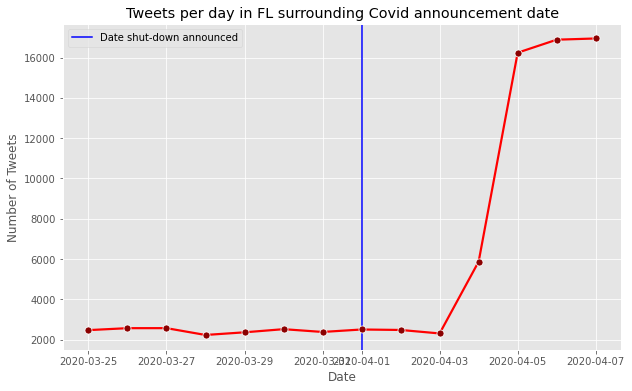

In [18]:
plot_tweets_per_day(state_shutdown_df, '2020-04-01')

In [19]:
def plot_top_and_bottom_tweeting_cities(data):
    top_tweeting_cities = data.groupby('city').count()['username'].sort_values().tail(10)
    bottom_tweeting_cities = data.groupby('city').count()['username'].sort_values().head(10)
    
    fig, ax = plt.subplots(nrows=2, figsize=(10, 12))
    
    top_tweeting_cities.plot(kind='barh',
                         x=top_tweeting_cities.index,
                         y=top_tweeting_cities.values,
                         ax=ax[0],
                         color='darkred')

    ax[0].set_title(f'Top 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[0].set_ylabel('City Name', size=16)
    ax[0].set_xlabel('Number of Tweets', size=16)
    ax[0].set_yticklabels([label.title() for label in top_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12);
    
    bottom_tweeting_cities.plot(kind='barh',
                     x=bottom_tweeting_cities.index,
                     y=bottom_tweeting_cities.values,
                     ax=ax[1],
                     color='darkblue')

    ax[1].set_title(f'Bottom 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[1].set_ylabel('City Name', size=16)
    ax[1].set_xlabel('Number of Tweets', size=16)
    ax[1].set_yticklabels([label.title() for label in bottom_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12)
    plt.tight_layout();

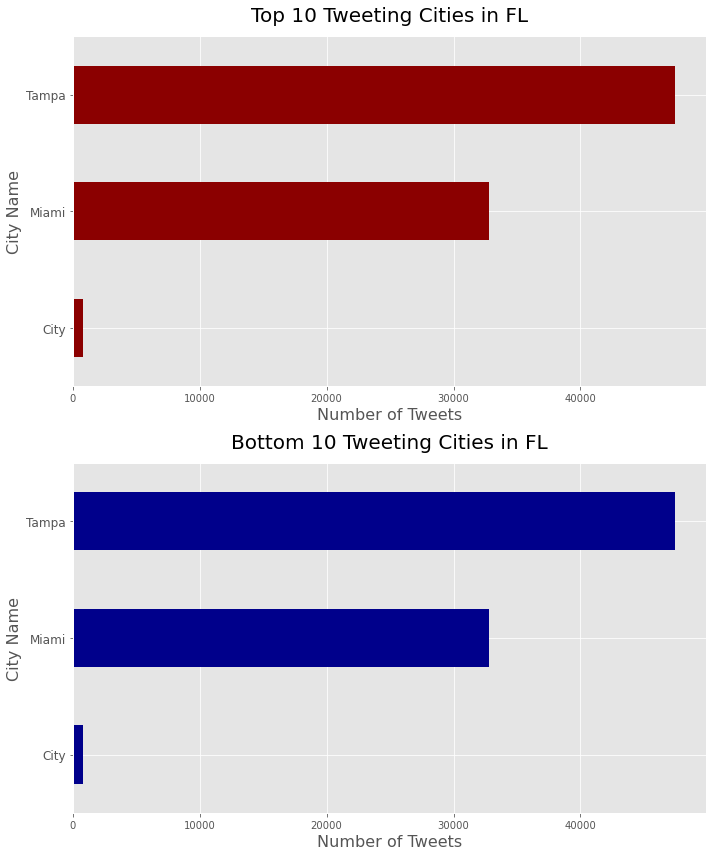

In [20]:
plot_top_and_bottom_tweeting_cities(state_shutdown_df)

In [21]:
city_tweets_per_day = state_shutdown_df.groupby(['city', 'year_month_day']).count()[['username']]

In [22]:
city_tweets_per_day.T['tampa'].T.index

Index([2020-04-04, 2020-04-05, 2020-04-06, 2020-04-07], dtype='object', name='year_month_day')

In [23]:
def plot_city_tweets_per_day(data, city, date):
    '''
    Need to have "state_shutdown_df" defined
    '''
    sort_dates = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    city_tweets_per_day = data.groupby(['city', 'year_month_day']).count()[['username']]
    city_tweets_per_day.T[city].T.plot(figsize=(10, 6), linewidth=2.2, marker='o')
    plt.title(f'Tweets Over Time in {city.title()}')
    plt.axvline(date, color='darkblue')
    plt.legend(['_', 'Date of shutdown announcement']);

/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdca0631490> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


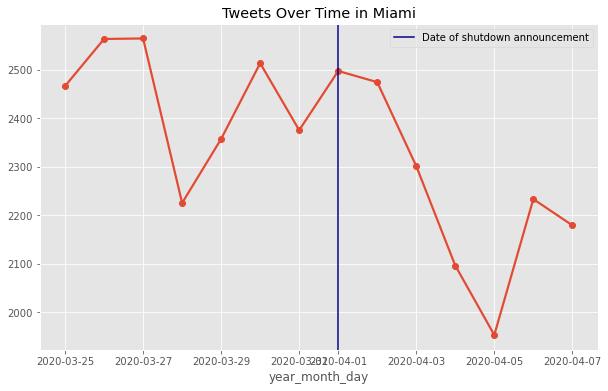

In [24]:
plot_city_tweets_per_day(state_shutdown_df, 'miami', '2020-04-01')

In [25]:
stop_words = ['http', 'https', 'igshid', 'becau']

In [26]:
def tokenize_and_stem(text, stemmer=True):
    '''
    This does more than just tokenize and stem! The code removes links and
    html artifacts and is great for dirty data scraped from Reddit.
    
    Needs to be run within a loop to work properly.
    '''
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]

    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stem the tokens
    p_stemmer = PorterStemmer()
    return [p_stemmer.stem(i) for i in tokens]

def tokenize(text):
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]
    
    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

In [27]:
custom_sw = stopwords.words('english') + stop_words
processed_sw = tokenize_and_stem(' '.join(custom_sw))

In [28]:
custom_sw = stopwords.words('english') + stop_words
processed_sw = tokenize_and_stem(' '.join(custom_sw))

In [29]:
# print(state_shutdown_df['text'].shape)
# state_shutdown_df['text'].dropna().shape

In [30]:
cvec_processed_sw = tokenize(' '.join(custom_sw))

cvec = CountVectorizer(stop_words=custom_sw, tokenizer=tokenize)
cvec_fit = cvec.fit(state_shutdown_df['text'])
cvec_transform = cvec.transform(state_shutdown_df['text'])

cvec_df = pd.DataFrame(cvec_transform.todense(),
                 columns=cvec_fit.get_feature_names())

cvec_df.head()

/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,0,00,000,000000,00000000000000000000000000000000000000000000,000001,00004,0000456,000048,00006,...,𝚌𝚘𝚛𝚘𝚗𝚊𝚟𝚒𝚛𝚞𝚜,𝚠𝚑𝚢,𝟑𝟑𝟎𝟏,𝟘𝟜,𝟙𝟘,𝟚𝟘𝟚𝟘,𝟬𝟬,𝟭𝟬𝘁𝗵,𝟭𝟱,𝟮
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
top_words_cvec = {}
for column in tqdm(cvec_df.columns):
    top_words_cvec[column] = cvec_df[column].sum()

most_freq_cvec = pd.DataFrame(sorted(top_words_cvec.items(), key = lambda x: x[1], reverse=True))

100%|██████████| 67699/67699 [07:01<00:00, 160.46it/s]


In [32]:
most_freq_cvec.to_csv('./data/top_words_cvec.csv', index=False)

In [33]:
most_freq_cvec.head(200)[0].tolist()

['get',
 'one',
 'people',
 'time',
 'know',
 'go',
 'need',
 'day',
 'like',
 'right',
 'today',
 'going',
 'home',
 'coronavirus',
 'quarantine',
 'us',
 'florida',
 'back',
 'good',
 'miami',
 'got',
 'virus',
 'would',
 'let',
 'see',
 'trump',
 'covid',
 'want',
 'love',
 'work',
 'stay',
 'make',
 'think',
 'still',
 'new',
 'really',
 '19',
 'even',
 '2',
 'every',
 'take',
 'shit',
 'lol',
 'please',
 'first',
 'de',
 'news',
 'help',
 'way',
 'much',
 'never',
 'life',
 'say',
 'many',
 'thank',
 '1',
 '3',
 'covid19',
 'great',
 'pandemic',
 'said',
 'well',
 'best',
 'u',
 'keep',
 'everyone',
 'could',
 'better',
 'thing',
 'come',
 'live',
 'man',
 'last',
 'always',
 'world',
 'getting',
 'week',
 'el',
 'another',
 'stop',
 'ever',
 'also',
 'god',
 'look',
 'next',
 'happy',
 'made',
 'health',
 'things',
 'en',
 'money',
 'someone',
 'feel',
 'something',
 'hope',
 'family',
 'que',
 'days',
 'real',
 '4',
 'house',
 'gonna',
 'la',
 'text',
 'president',
 'call',
 'tr

## EDA on Florida Reopening Data

In [6]:
state_reopening = pd.read_csv('./data/reopening_data/FL_full.csv')

In [7]:
state_reopening.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69410 entries, 0 to 69409
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   username        69410 non-null  object 
 1   to              31697 non-null  object 
 2   text            69410 non-null  object 
 3   retweets        69410 non-null  int64  
 4   favorites       69410 non-null  int64  
 5   replies         69410 non-null  int64  
 6   id              69410 non-null  int64  
 7   permalink       69410 non-null  object 
 8   author_id       69410 non-null  int64  
 9   date            69410 non-null  object 
 10  formatted_date  69410 non-null  object 
 11  hashtags        10967 non-null  object 
 12  mentions        8767 non-null   object 
 13  geo             0 non-null      float64
 14  urls            18970 non-null  object 
 15  city            69410 non-null  object 
 16  query           69410 non-null  object 
 17  date_range      69410 non-null 

In [8]:
state_reopening['city']

0        miami
1        miami
2        miami
3        miami
4        miami
         ...  
69405    tampa
69406    tampa
69407    tampa
69408    tampa
69409    tampa
Name: city, Length: 69410, dtype: object

In [9]:
state_reopening.groupby('city').count()['id'].sort_values(ascending=False)

city
tampa    43958
miami    25452
Name: id, dtype: int64

In [10]:
state_reopening_df = state_reopening.copy()[['username', 'text', 'date', 'city', 'state', 'month', 'day']]

In [11]:
# state_reopening_df['date']

In [12]:
state_reopening_df['date'] = pd.to_datetime(state_reopening_df['date'], utc=True)

In [13]:
# Creating year month day column because we'll need a way to sort dates across months
state_reopening_df['year_month_day'] = state_reopening_df['date'].dt.date

In [14]:
# state_reopening_df.info()

In [15]:
state_reopening_df['year_month_day'].sort_values()

24689    2020-04-22
25228    2020-04-22
25227    2020-04-22
25226    2020-04-22
25225    2020-04-22
            ...    
31875    2020-05-05
31874    2020-05-05
31873    2020-05-05
31882    2020-05-05
34704    2020-05-05
Name: year_month_day, Length: 69410, dtype: object

In [16]:
state_reopening_df.groupby('year_month_day').count()

,username,text,date,city,state,month,day
year_month_day,,,,,,,
2020-04-22,1939,1939,1939,1939,1939,1939,1939
2020-04-23,2092,2092,2092,2092,2092,2092,2092
2020-04-24,2188,2188,2188,2188,2188,2188,2188
2020-04-25,1628,1628,1628,1628,1628,1628,1628
2020-04-26,1672,1672,1672,1672,1672,1672,1672
2020-04-27,1797,1797,1797,1797,1797,1797,1797
2020-04-28,1822,1822,1822,1822,1822,1822,1822
2020-04-29,1793,1793,1793,1793,1793,1793,1793
2020-04-30,1926,1926,1926,1926,1926,1926,1926


In [17]:
plot_tweets_per_day(state_reopening_df, '2020-04-29')

NameError: name 'plot_tweets_per_day' is not defined

In [ ]:
def plot_top_and_bottom_tweeting_cities(data):
    top_tweeting_cities = data.groupby('city').count()['username'].sort_values().tail(10)
    bottom_tweeting_cities = data.groupby('city').count()['username'].sort_values().head(10)
    
    fig, ax = plt.subplots(nrows=2, figsize=(10, 12))
    
    top_tweeting_cities.plot(kind='barh',
                         x=top_tweeting_cities.index,
                         y=top_tweeting_cities.values,
                         ax=ax[0],
                         color='darkred')

    ax[0].set_title(f'Top 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[0].set_ylabel('City Name', size=16)
    ax[0].set_xlabel('Number of Tweets', size=16)
    ax[0].set_yticklabels([label.title() for label in top_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12);
    
    bottom_tweeting_cities.plot(kind='barh',
                     x=bottom_tweeting_cities.index,
                     y=bottom_tweeting_cities.values,
                     ax=ax[1],
                     color='darkblue')

    ax[1].set_title(f'Bottom 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[1].set_ylabel('City Name', size=16)
    ax[1].set_xlabel('Number of Tweets', size=16)
    ax[1].set_yticklabels([label.title() for label in bottom_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12)
    plt.tight_layout();

In [ ]:
plot_top_and_bottom_tweeting_cities(state_reopening_df)

In [18]:
city_tweets_per_day = state_reopening_df.groupby(['city', 'year_month_day']).count()[['username']]

In [19]:
city_tweets_per_day.T['miami'].T.index

Index([2020-04-22, 2020-04-23, 2020-04-24, 2020-04-25, 2020-04-26, 2020-04-27,
       2020-04-28, 2020-04-29, 2020-04-30, 2020-05-01, 2020-05-02, 2020-05-03,
       2020-05-04, 2020-05-05],
      dtype='object', name='year_month_day')

In [20]:
def plot_city_tweets_per_day(data, city, date):
    '''
    Need to have "state_shutdown_df" defined
    '''
    sort_dates = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    city_tweets_per_day = data.groupby(['city', 'year_month_day']).count()[['username']]
    city_tweets_per_day.T[city].T.plot(figsize=(10, 6), linewidth=2.2, marker='o')
    plt.title(f'Tweets Over Time in {city.title()}')
    plt.axvline(date, color='darkblue')
    plt.legend(['_', 'Date of shutdown announcement']);

/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7faa42826f10> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


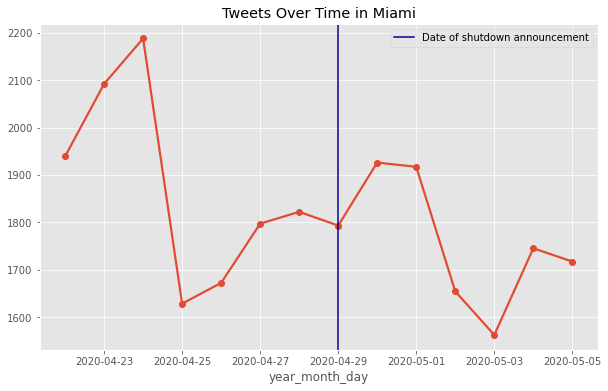

In [21]:
plot_city_tweets_per_day(state_reopening_df, 'miami', '2020-04-29')

In [22]:
stop_words = ['http', 'https', 'igshid', 'becau']

In [23]:
def tokenize_and_stem(text, stemmer=True):
    '''
    This does more than just tokenize and stem! The code removes links and
    html artifacts and is great for dirty data scraped from Reddit.
    
    Needs to be run within a loop to work properly.
    '''
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]

    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stem the tokens
    p_stemmer = PorterStemmer()
    return [p_stemmer.stem(i) for i in tokens]

def tokenize(text):
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]
    
    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

In [24]:
custom_sw = stopwords.words('english') + stop_words
processed_sw = tokenize_and_stem(' '.join(custom_sw))

In [25]:
cvec_processed_sw = tokenize(' '.join(custom_sw))

cvec = CountVectorizer(stop_words=custom_sw, tokenizer=tokenize)
cvec_fit = cvec.fit(state_reopening_df['text'])
cvec_transform = cvec.transform(state_reopening_df['text'])

cvec_df = pd.DataFrame(cvec_transform.todense(),
                 columns=cvec_fit.get_feature_names())

cvec_df.head()

/Users/haleytaft/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,0,00,000,0000,0000289201,00005,0001955,0002,000and,000ft,...,𝙁𝙡𝙚𝙭,𝙁𝙧𝙞𝙙𝙖𝙮,𝙉𝙚𝙬,𝙍𝙖𝙛𝙖𝙚𝙡,𝙍𝙚𝙖𝙡𝙩𝙤𝙧,𝙕𝙪𝙯𝙤𝙡𝙤,𝙿𝚊𝚛𝚒𝚜,𝟏𝟎,𝟒𝐂𝐑𝐄𝐀𝐓𝐈𝐕𝐄𝐒,𝟔
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
top_words_cvec = {}
for column in tqdm(cvec_df.columns):
    top_words_cvec[column] = cvec_df[column].sum()

most_freq_cvec = pd.DataFrame(sorted(top_words_cvec.items(), key = lambda x: x[1], reverse=True))

100%|██████████| 67793/67793 [06:53<00:00, 164.07it/s]


In [27]:
most_freq_cvec.to_csv('./data/top_words_cvec_fl.csv', index=False)

In [28]:
most_freq_cvec.head(200)[0].tolist()

['get',
 'one',
 'people',
 'know',
 'time',
 'day',
 'go',
 'today',
 'need',
 'like',
 'right',
 'going',
 'home',
 'back',
 'good',
 'florida',
 'us',
 'would',
 'love',
 'got',
 'see',
 'want',
 'let',
 'think',
 'make',
 'new',
 'really',
 'miami',
 'trump',
 'still',
 'even',
 'quarantine',
 'work',
 'first',
 'coronavirus',
 'never',
 '2',
 'happy',
 'every',
 'great',
 'way',
 'lol',
 'covid',
 'much',
 'take',
 'shit',
 'may',
 'say',
 'life',
 '19',
 'news',
 '1',
 'many',
 'de',
 'u',
 'best',
 'thank',
 'virus',
 'always',
 'well',
 '3',
 'help',
 'could',
 'last',
 'man',
 'better',
 'come',
 'please',
 'ever',
 'thing',
 'said',
 'beach',
 'feel',
 'live',
 'stay',
 'also',
 'year',
 'look',
 'years',
 'next',
 'everyone',
 'getting',
 'another',
 'keep',
 'things',
 'something',
 'hope',
 'pandemic',
 'someone',
 'made',
 'week',
 '5',
 'open',
 'real',
 'world',
 'money',
 'god',
 'family',
 'long',
 '4',
 'give',
 'sure',
 'done',
 'since',
 'wait',
 'stop',
 'two',
 '